In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
40988,"Over 10,000 people watch CSK's intra-squad pra...","Over 10,000 fans of IPL franchise Chennai Supe..."
93075,Google tool hides search result for airline th...,A Google Chrome extension called 'DropUnited' ...
92098,China launches campaign to teach students how ...,The Communist Party of China has launched a ca...
36873,CM Manohar Parrikar skips morning session of G...,Goa CM Manohar Parrikar on Thursday skipped th...
67472,Disabled man abused for not standing up for Na...,A 36-year-old wheelchair-bound man from Guwaha...
64855,"Tipu Sultan was anti-Hindu, anti-Kannada: Unio...","Terming Tipu Sultan as ""anti-Hindu and anti Ka..."
24952,Yo-Yo test shouldnÃ¢ÂÂt be sole selection cr...,Former Indian cricketer Sachin Tendulkar said ...
47644,Billionaire Singh brothers quit Religare board...,Billionaire brothers Malvinder and Shivinder S...
29093,"ABD, Kohli, Dhoni my career's 3 best dismissal...",Afghanistan's 19-year-old spinner Rashid Khan ...
40809,'Computer Baba' cancels protest after being ma...,Religious leaders Computer Baba and Yogendra M...


뉴스 기사의 헤드라인과 뉴스 기사 전문으로 이루어진 걸 보니, 이전 LMS에서 다뤘던 Summary에 headlines가 해당하는 것으로 보인다.

# 데이터 전처리하기 (추상적 요약)

In [4]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 : ', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 : ', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 :  98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 :  98280


In [5]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿈
data.drop_duplicates(subset = ["text"], inplace=True)
print('전체 샘플 수 :', (len(data)))

전체 샘플 수 : 98360


### 결측치 확인하기

In [6]:
print(data.isnull().sum())
#결측치 없음

headlines    0
text         0
dtype: int64


## 텍스트 정규화와 불용어 제거

### 텍스트 정규화를 위한 사전(dictionary)

In [7]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [8]:
print('정규화 사전의 수 : ', len(contractions))

정규화 사전의 수 :  120


### 불용어

In [9]:
# NLTK에서 제공하는 불용어 리스트
print('불용어 개수 : ', len(stopwords.words('english')))
print(stopwords.words('english'))

불용어 개수 :  179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', '

## 데이터 전처리 함수

- **NLTK를 통해 불용어(stopwords) 제거**

: text에서만 적용. 

이미 상대적으로 문장 길이가 짧은 headlines에서 불용어를 삭제하면,

Abstractive한 문장 요약 결과문이 자연스럽지 않을 것.

In [10]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()  #텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text  # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    #불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    #불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word)>1)
    return tokens

## 훈련 데이터 전체에 대해 적용
- Text : 불용어 제거
- Summary : 불용어 제거 X
- Text, Summary 따로 호출해서 처리

### Text 전처리

In [11]:
clean_text = []
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

### headlines 전처리

In [12]:
clean_headlines = []
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s))

정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수도 있기 때문에

텍스트 정제의 과정을 거친 후에 다시 한 번 **빈(empty) 샘플**이 생겼는지 확인

**쉽게 확인하기 위해 데이터들을 데이터 프레임에 저장**
- 빈(empty) 값을 가진 샘플들이 있다면 모두 Null값을 가진 샘플로 대체

In [13]:
data['text'] = clean_text
data['headlines'] = clean_headlines

#빈 값을 Null값으로 반환
data.replace('', np.nan, inplace=True)

In [14]:
#결측치 확인
data.isnull().sum()

#결측치 없음!

headlines    0
text         0
dtype: int64

### 데이터의 길이 시각화

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
기사제목의 최소 길이 : 1
기사제목의 최대 길이 : 13
기사제목의 평균 길이 : 7.136183407889386


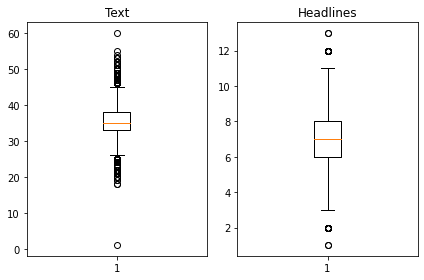

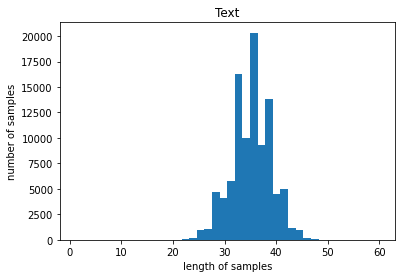

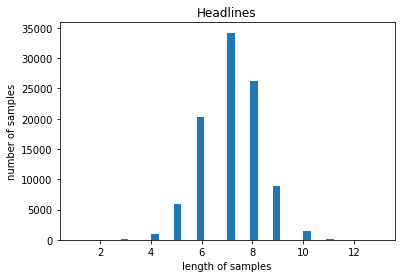

In [15]:
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('기사제목의 최소 길이 : {}'.format(np.min(headlines_len)))
print('기사제목의 최대 길이 : {}'.format(np.max(headlines_len)))
print('기사제목의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(headlines_len , bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### Text, Headlines의 적절한 최대길이를 임의로 지정

In [16]:
text_max_len = 45
headlines_max_len = 10

box plot 을 기준으로 (Q3 + 1.5 * IQR)에 해당하는 Maximum line을 기준으로 max_len을 설정했다.

### 훈련 데이터와 샘플의 길이를 입력하면 데이터의 몇%가 해당되는지 계산하는 함수

In [17]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split())) <= max_len:
            cnt += 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율 : %s'%(max_len, (cnt/len(nested_list)) ))

In [18]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율 : 0.9967771451809678
전체 샘플 중 길이가 10 이하인 샘플의 비율 : 0.9978344855632371


max len값을 설정한 의미가 없을 정도로 너무 많이 포함되는 것 같아서 max_len의 값을 줄여보았다.

In [23]:
text_max_len = 40
headlines_max_len = 9

In [24]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율 : 0.9238714924766165
전체 샘플 중 길이가 9 이하인 샘플의 비율 : 0.9826250508336722


### 정해진 길이에 맞춰 자르는 것이 아니라, 정해진 길이보다 길면 제외하는 방식으로 정제

In [25]:
data = data[data['text'].apply(lambda x : len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x : len(x.split()) <= headlines_max_len)]

In [26]:
print('전체 샘플 수 : ', len(data))

전체 샘플 수 :  89517


## 시작 토큰과 종료 토큰 추가하기
- 디코더는 시작 토큰을 입력받아 문장을 생성하기 시작하고, 종료토큰을 예측한 순간에 문장 생성을 멈춤

In [27]:
#시작 토큰 : sostoken
#종료 토큰 : eostoken
#디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름 : decoder_input
#디코더의 출력 또는 레이블에 해당하면서 종료 토큰이 맨 뒤에 붙는 문장의 이름 : decoder_target

#요약 데이터에 시작 토큰과 종료 토큰을 추가
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken ' + x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')

data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches career ml al salary hike,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches career ml al ...,upgrad learner switches career ml al salary hi...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,known hirani yrs metoo claims true sonam,speaking sexual harassment allegations rajkuma...,sostoken known hirani yrs metoo claims true sonam,known hirani yrs metoo claims true sonam eostoken
5,rahat fateh ali khan denies getting notice smu...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice smu...
6,india get lowest odi total new zealand,india recorded lowest odi total new zealand ge...,sostoken india get lowest odi total new zealand,india get lowest odi total new zealand eostoken


시작 토큰과 종료 토큰이 잘 적용되었다.

### 인코더의 입력, 디코더의 입력과 레이블을 각각 numpy 타입으로 저장

In [28]:
encoder_input = np.array(data['text'])  #인코더의 입력
decoder_input = np.array(data['decoder_input'])   #디코더의 입력
decoder_target = np.array(data['decoder_target'])  #디코더의 레이블

## 훈련 데이터, 테스트 데이터 분리

### encoder_input 크기와 형태가 같은 순서가 섞인 정수 시퀀스 생성

In [29]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices) #랜덤으로 섞기
print(indices)

[64572 17351 17511 ... 26284 68179  4926]


In [30]:
encoder_input.shape

(89517,)

In [31]:
np.arange(encoder_input.shape[0])

#encoder_input.shape[0] : encoder_input의 개수
#그만큼 정수 생성 (0부터 81913까지)

array([    0,     1,     2, ..., 89514, 89515, 89516])

In [32]:
indices
#잘 섞임

array([64572, 17351, 17511, ..., 26284, 68179,  4926])

### indices를 이용해 다시 데이터의 샘플 순서를 정의

In [33]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

### 8:2 비율로 분리

In [34]:
n_of_val = int(len(encoder_input) * 0.2)
print('테스트 데이터의 수 : ', n_of_val)

테스트 데이터의 수 :  17903


In [35]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 71614
훈련 레이블의 개수 : 71614
테스트 데이터의 개수 : 17903
테스트 레이블의 개수 : 17903


## 단어 집합 만들기 및 정수 인코딩
- 각 단어에 고유한 정수를 맵핑하는 작업

In [36]:
#원문에 해당하는 encoder_input_train에 대해서 단어집합 생성

src_tokenizer = Tokenizer()    # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train)   #입력된 데이터로부터 단어 집합 생성

#생성된 단어 집합은 src_tokenizer.word_index에 저장되어 있음

- **src_tokenizer.word_counts.items()**에는 각 단어의 등장 빈도수가 저장되어 있는데,

  이를 통해서 통계적인 정보를 얻을 수 있음.
  
  
### 등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는 지 확인

In [37]:
threshold = 7
total_cnt = len(src_tokenizer.word_index)  #단어의 수
rare_cnt = 0   #등장 빈도수가 threshold 보다 작은 단어의 개수를 카운트
total_freq = 0  #훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0   #등장 빈도수가 threshold보다 작은 단어의 등장 빈도수 총 합

#단어와 빈도수의 쌍(pair)을 key와 value로 받음
for key, value in src_tokenizer.word_counts.items():   # 딕셔너리 형태
    total_freq = total_freq + value
    
    #단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
        
print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 65358
등장 빈도가 6번 이하인 희귀 단어의 수: 44490
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20868
단어 집합에서 희귀 단어의 비율: 68.07123840998807
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.664432595625583


등장 빈도가 6회 이하인 단어들은 단어 집합에서 약 68%를 차지하지만, 실제로 훈련 데이터에서 적은 수치인 3.66%

따라서 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련데이터에서 제거.

이를 제거한 단어 집합의 크기를 약 20,000개로 제한

- Tokenizer 정의할 때 num_words를 지정해주면 단어집합의 크기 제한 가능
- **Tokenizer는 단어의 빈도수가 많은 순서대로 처리됨**

In [38]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

- **text_to_sequence()**

: 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩

- 단어 집합의 크기를 20,000으로 제한했으니 20,000이 넘는 숫자들은 숫자 인코딩 후에는 데이터에 존재 X

In [39]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

### headlines에 대해서도 동일한 작업 수행

In [40]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

### 등장 빈도 수가 5회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는 지 확인

In [42]:
threshold = 5
total_cnt = len(tar_tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28500
등장 빈도가 4번 이하인 희귀 단어의 수: 17622
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10878
단어 집합에서 희귀 단어의 비율: 61.83157894736843
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.270902708246208


등장 빈도가 4회 이하인 단어들은 단어 집합에서 약 61%를 차지하지만, 

실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 5.27%밖에 되지 않음.

어림잡아 10,000 단어 집합의 크기로 제한

In [43]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

### Headlines 빈 샘플 지우기

전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은

빈도수가 낮은 단어만으로 구성되었던 샘플들은 빈 샘플이 되었을 가능성 존재

**주의할 점 !**

decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태

이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높음

단어 집합 제한에도 삭제되지 않음

따라서 **길이가 0이 된 요약문의 실제 길이는 1**

길이가 0이 된 decoder_input에는 sostoken

decoder_target에는 eostoken만 남아 있기 때문

In [44]:
#기사 제목에서 길이가 0이 된 샘플의 인덱스를 받아 삭제를 진행
#요약문에는 sostoken, eostoken이 추가된 상태이므로 단어 집합 제한에 걸리지 않음
#즉, 길이가 0이 된 요약문의 길이는 1

drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

#삭제할 데이터가 아주 소량

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 71613
훈련 레이블의 개수 : 71613
테스트 데이터의 개수 : 17903
테스트 레이블의 개수 : 17903


### 패딩하기
- 정해두었던 최대길이로 패딩
- 최대 길이보다 짧은 데이터들은 0을 뒤에 넣어 최대길이로 맞춰줌

In [45]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

# 모델 설계하기

## 인코더 설계

In [46]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#인코더 설계 시작
embedding_dim = 128
hidden_size = 256

#인코더
encoder_inputs = Input(shape=(text_max_len,))

#인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

#인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences = True, return_state=True, dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

#출력된 건 recurrent dropout을 사용해서 발생한 경고
#recurrent dropout을 사용할 시 cuDNN을 사용할 수 없어서 recurrent dropout을 사용하지 않을 때보다 학습 시간이 오래 걸림

- **hidden_state** : LSTM에서 얼만큼의 수용력(capacity)를 가질지 정하는 파라미터. LSTM의 크기, LSTM에서의 뉴런의 개수

인코더의 LSTM은 **총 3개의 층으로 구성해서 모델의 복잡도를 높임**

hidden_state가 LSTM 층 1개의 용량을 늘린다면,

3개의 층을 사용하는 것은 모델의 용량을 늘리는 것.

- **dropout** : 레이어의 weight를 랜덤으로 생략하여 모델의 과적합을 해결해주는 방법
- **recurrent dropout** : dropout을 레이어가 아닌 time step마다 해주는 방식. time step의 입력을 랜덤으로 생략. regularization, 과적합 방지
- **Variational Dropout** : dropout과 recurrent dropout을 같이 사용한 방식

## 디코더 설계

In [47]:
decoder_inputs = Input(shape=(None,))

#디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

#디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

디코더의 임베딩층과 LSTM을 설계하는 것은 인코더와 거의 동일하지만

LSTM의 입력을 정의할 때 **initial_state의 인자값으로 인코더의 hidden state와 cell state의 값**을 넣어줘야 함

### 어텐션 매커니즘을 활용한 디코더 출력층 설계

In [48]:
from tensorflow.keras.layers import AdditiveAttention

#어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

#인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

#어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

#모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

디코더의 출력층에서는 Summary의 단어장인 tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는 **다중 클래스 분류 문제**를 풀어야 함

그렇기 때문에 **Dense의 인자로 tar_vocab**을 주고 활성화 함수로 **softmax 함수를 사용**

In [49]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
                 # val_loss(검증 데이터의 손실)를 관찰하다가 검증 데이터의 손실이 증가하는 현상이 2회(patience=2) 관측되면 학습을 멈춤
                 # EarlyStopping이 작동한다면 epochs가 아무리 많아도 모델 훈련을 최적점에서 멈출 수 있음
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
280/280 [==============================] - 157s 530ms/step - loss: 6.1530 - val_loss: 5.7977
Epoch 2/50
280/280 [==============================] - 147s 526ms/step - loss: 5.6178 - val_loss: 5.4286
Epoch 3/50
280/280 [==============================] - 148s 529ms/step - loss: 5.2909 - val_loss: 5.1470
Epoch 4/50
280/280 [==============================] - 148s 528ms/step - loss: 5.0134 - val_loss: 4.9082
Epoch 5/50
280/280 [==============================] - 150s 535ms/step - loss: 4.7686 - val_loss: 4.7523
Epoch 6/50
280/280 [==============================] - 149s 531ms/step - loss: 4.5677 - val_loss: 4.6212
Epoch 7/50
280/280 [==============================] - 148s 528ms/step - loss: 4.4021 - val_loss: 4.5320
Epoch 8/50
280/280 [==============================] - 147s 526ms/step - loss: 4.2592 - val_loss: 4.4549
Epoch 9/50
280/280 [==============================] - 146s 523ms/step - loss: 4.1303 - val_loss: 4.4002
Epoch 10/50
280/280 [==============================] - 147s 524m

# 인퍼런스 모델 구현

테스트 단계에서는 **정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원**해야 하므로, 

필요한 3개의 사전을 아래와 같이 미리 준비

In [50]:
src_index_to_word = src_tokenizer.index_word #원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index #요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word #요약 단어 집합에서 정수 -> 단어를 얻음

- **seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 함**

: **훈련 단계**에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 

 인코더와 디코더를 엮은 통짜 모델 하나만 준비
 
: 정답 문장이 없는 **인퍼런스 단계**에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 

 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 함 
 
 이때는 인코더 모델과 디코더 모델을 분리해서 설계

In [51]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해 초기상태(initial_state)를 이전 시점의 상태로 사용
# 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [55]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [59]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c
        
    return decoded_sentence

# 모델 테스트하기
- 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인

### 주어진 시퀀스를 텍스트 시퀀스로 변환하는 함수

- Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고

- Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력해서 제외

In [60]:
#원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i] + ' '
    return temp

#요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [63]:
for i in range(50, 70):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

예측 요약 :  women introduce women women work govt


원문 : year old accused killing people rifle school florida us blamed voice head massacre cruz said constant battle voice told burn kill destroy said attempted suicide two months attack 
실제 요약 : florida shooter blames demon head killing 
예측 요약 :  us teacher killed shooting teacher


원문 : world consumer rights day inspired former us president john kennedy formally addressed issue consumer rights message us congress march day first observed march since celebrated yearly raise global awareness rights needs consumers 
실제 요약 : world consumer day inspired former us prez kennedy 
예측 요약 :  obama named president macron


원문 : cbi officer charge dhar mishra lodged fir alleged irregularities loan icici bank transferred delhi jharkhand development comes cbi charged icici bank former md ceo chanda kochhar husband deepak kochhar videocon dhoot cheating conspiracy dhar signed fir january 
실제 요약 : cbi officer probed icici bank chanda kochhar case transfer

# Summa를 이용한 추출적 요약

앞서 seq2seq를 통해서 추상적 요약 진행. 텍스트 요약에는 추상적 요약 외에도 

이미 본문에 존재하는 단어구, 문장을 뽑아서 요약으로 삼는 추출적 요약 방법이 있음

In [4]:
import requests
from summa.summarizer import summarize

## Summarize 사용하기
**Summa의 summarize()의 인자로 사용되는 값들**
- **text(str)** : 요약할 텍스트


- **ratio(float, optional)** : 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값


- **words (int or None, optional)** : 출력에 포함할 단어 수.
   (만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시)


- **split (bool, optional)** : True면 문장 list / False는 조인(join)된 문자열을 반환

Summa의 summarize()는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화 수행

따라서 문장 구분이 되어있지 않은 원문 바로 입력 가능

- 단어의 수로 요약문의 크기 조절 가능

In [12]:
Summ_headlines = []
for s in data['text']:
    Summ_headlines.append(summarize(s, words=15))

In [14]:
data['Summ_headlines'] = Summ_headlines

In [26]:
data['Summ_headlines'] = data['Summ_headlines'].replace('', 'No Summary')

In [27]:
data[['headlines', 'Summ_headlines']]

,headlines,Summ_headlines
0,upGrad learner switches to career in ML & Al w...,upGrad's Online Power Learning has powered 3 l...
1,Delhi techie wins free food from Swiggy for on...,Users get one CRED coin per rupee of bill paid...
2,New Zealand end Rohit Sharma-led India's 12-ma...,The match witnessed India getting all out for ...
3,Aegon life iTerm insurance plan helps customer...,"Also, customers have options to insure against..."
4,"Have known Hirani for yrs, what if MeToo claim...",No Summary
...,...,...
98396,CRPF jawan axed to death by Maoists in Chhatti...,A CRPF jawan was on Tuesday axed to death with...
98397,First song from Sonakshi Sinha's 'Noor' titled...,"'Uff Yeh', the first song from the Sonakshi Si..."
98398,'The Matrix' film to get a reboot: Reports,Michael B Jordan will reportedly play the lead...
98399,Snoop Dogg aims gun at clown dressed as Trump ...,The video also shows a TV airing a news confer...


In [28]:
for i in range(50, 70):
    print('실제 Headline : ', data['headlines'][i] )
    print('Summa 사용 Headline : ', data['Summ_headlines'][i])
    print("\n")

실제 Headline :  Yashwant Sinha demands probe into alleged fund diversion by DHFL
Summa 사용 Headline :  Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).


실제 Headline :  Boeing sales cross $100bn for 1st time in its 102-yr history
Summa 사용 Headline :  Boeing retained its position as the world's largest planemaker for the seventh straight year, delivering 806 aircraft in 2018.


실제 Headline :  headlines
Summa 사용 Headline :  No Summary


실제 Headline :  OnePlus named bestselling premium smartphone brand of 2018: Report
Summa 사용 Headline :  Further, its OnePlus 6 emerged as the highest selling premium smartphone of 2018 followed by OnePlus 6T.


실제 Headline :  Can never look at female body, even if naked, in vulgar way: Pooja
Summa 사용 Headline :  No Summary


실제 Headline :  Kangana made fake promises to cast: 'Manikarnika' actress Mishti
Summa 사용 Headline :  Actress Mishti, who has 

# 회고

**어텐션 매커니즘을 활용한 추상적 요약**을 진행했을 때, validation loss 값이 4점 대여서 그런지 요약이 잘 되었다는 느낌을 받진 못했다.

몇몇 문장은 다음과 같이 핵심 키워드를 포함하여 예측 요약과 실제 요약의 내용이 비슷했지만,

실제 요약 : google hate group ex employee 

예측 요약 : google sued ex employee employee fired

다음과 같이 애초에 번역조차 되지 않는 문장을 생성하기도 했다.

예측 요약 : mj akbar mj akbar resigns metoo allegations

----------------

기존 LMS에서 진행했던 데이터 요약은 데이터의 개수가 지금 프로젝트에 비해 현저히 적어서 높은 성능이 나온 것 같다는 생각이 들어,

인코더의 embedding_dim과 hidden_size를 더 높은 숫자로 지정했지만 오히려 성능이 저하되었다.

단어집합의 크기 또한 줄여보았지만 이 경우에도 성능이 저하된 것을 확인했다.

-----------------
**Summa를 활용한 추출적 요약**을 진행해보았다.

Headline의 평균 길이가 약 7이기 때문에 Summa를 사용한 요약을 진행할 때 words의 값을 7혹은 10으로 맞추려했다. 

하지만 그럴 경우 text 대부분의 요약문이 빈칸으로 반환되었다.

따라서 값을 상향조정했고, 20이상으로 될 경우 Headline과 비교할 만한 요약의 느낌이 아니라서 words의 값을 15로 지정했다.

words=15일 때에도 빈칸이 반환되는 경우가 있었고, replace함수를 사용하여 빈칸을 No Summary로 채웠다.

비록 요약이 아예 되지 않은 No Summary 컬럼이 존재하지만,

요약이 진행된 예측 컬럼은 실제 요약 내용에 해당하는 문장을 반환했다.

문법적인 측면에서도 월등했지만 추상적 요약에 비해 예측 요약 문장에 핵심 키워드를 포함하는 빈도는 더 적어보인다.

-----------
Summa Summarize를 진행할 때, 왜 words의 값이 작을 경우 빈칸이 반환되는 건지 궁금하다.

이리저리 구글링을 해보았는데, 이 부분에 있어서 명확한 답변이 되는 글을 찾지 못했다.

인퍼런스 모델의 개념이 아직 와닿지 않는다. 아마 더 접해봐야 이해를 할 수 있을 것 같다.

NLP가 딥러닝 중에 가장 이해하기 쉽고 구현하는 데에도 편할 것이라고 생각했던 

과거의 내가 정말 안일했던 것이었구나 라는 걸 깨달았다.